<a href="https://colab.research.google.com/github/YangJiao85/disaster-tweets-kaggle/blob/master/disaster_tweets_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? NLP with Disaster Tweets

In the dataset 10,000 tweets were hand classified. 

## Set up

Set up Kaggle environment and essential modules.

In [1]:
# Load essential modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import re
from IPython.core.display import HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Google colab Kaggle setting

os.environ['KAGGLE_USERNAME'] = # "xxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] =      # "xxxxxxxxxxxxxxxxxxxxxxxxxxxx" # key from the json file

! kaggle competitions download -c 'nlp-getting-started'
! ls -la /content

i_dir = "/content/"
o_dir = "/content/"
# if kaggle
# i_dir = "/kaggle/input/nlp-getting-started/"
# o_dir = "/kaggle/working/"

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 58.7MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.3MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.7MB/s]
total 1420
drwxr-xr-x 1 root root   4096 May  2 18:39 .
drwxr-xr-x 1 root root   4096 May  2 18:38 ..
drwxr-xr-x 1 root root   4096 Apr 29 16:14 .config
drwxr-xr-x 1 root root   4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root  22746 May  2 18:39 sample_submission.csv
-rw-r--r-- 1 root root 420783 May  2 18:39 test.csv
-rw-r--r-- 1 root root 987712 May  2 18:39 train.csv



## EDA and data preproccessing


### An quick view of the data

In [3]:
# load data
df_train = pd.read_csv(i_dir + '/train.csv')

print("This train dataset has {} entries and {} columns.".format(
    df_train.shape[0], df_train.shape[1]))
print("Features: ")
df_train_summary = pd.DataFrame( data = {
                     'dtype': df_train.dtypes.values,
                     'nunique': df_train.nunique()},
                     index = df_train.dtypes.index
                  )

df_train_summary

This train dataset has 7613 entries and 5 columns.
Features: 


,dtype,nunique
id,int64,7613
keyword,object,221
location,object,3341
text,object,7503
target,int64,2


In [4]:
display(HTML(df_train.head().to_html()))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
df_test = pd.read_csv(i_dir + '/test.csv')
print("This test dataset has {} entries and {} columns.".format(
    df_test.shape[0], df_test.shape[1]))
df_test.nunique()

This test dataset has 3263 entries and 4 columns.


id          3263
keyword      221
location    1602
text        3243
dtype: int64

In [6]:
df_sub = pd.read_csv(i_dir + 'sample_submission.csv')
df_sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


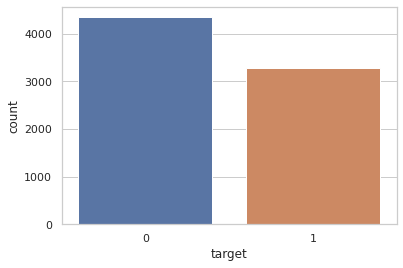

In [7]:
# plot target distribution
sns.countplot(x = 'target', data = df_train)
plt.show()

### location distribution

target  haslocation
0       0              1458
        1              2884
1       0              1075
        1              2196
dtype: int64


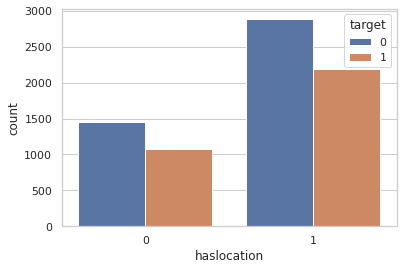

In [8]:
# If has location
df_train['haslocation'] = pd.notna(df_train['location']).astype(int)
print(df_train.groupby(by = ['target', 'haslocation']).size())

sns.countplot(x = 'haslocation', hue = 'target', data = df_train)
plt.show()

Number of locations:      3341
Tweets WITH a location:   5080
Tweets WITHOUT locations: 2533


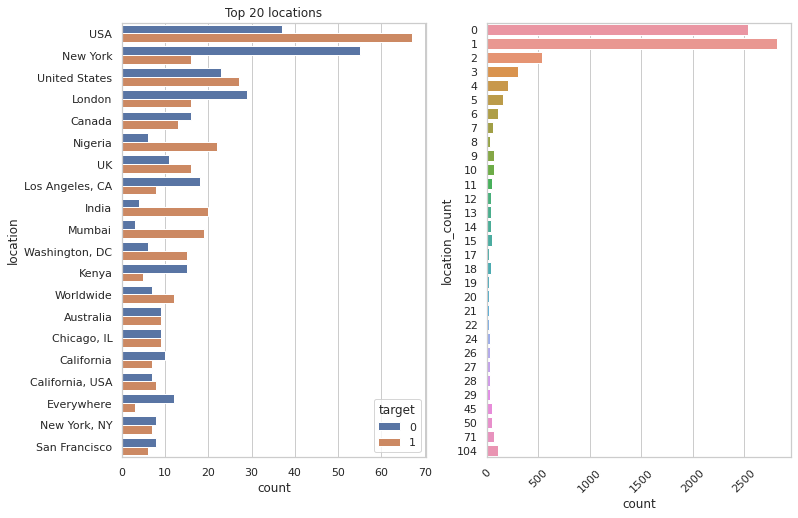

In [9]:
# plot location distributions
print("Number of locations:      {}".format(df_train['location'].nunique(dropna=True)))
print("Tweets WITH a location:   {}".format(pd.notna(df_train['location']).sum()))
print("Tweets WITHOUT locations: {}".format(pd.isna(df_train['location']).sum()))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))

sns.countplot(y='location', hue='target', data=df_train,
              order = df_train['location'].value_counts().iloc[:20].index,
              hue_order = [0, 1],
              ax = ax1)

ax1.set_title("Top 20 locations")

# Add a column location_freq
df_train_location_freq = df_train['location'].value_counts(dropna=True, ascending=False, normalize=True)
df_train.loc[:,'location_freq'] = 0
df_train['location_count'] = 0
for l in df_train['location'].unique():
    if(pd.isna(l)): continue
    df_train.loc[df_train['location'] == l, ['location_freq']] = df_train_location_freq.get(l, default = 0)
    df_train.loc[df_train['location'] == l, ['location_count']] = df_train[df_train['location']==l].shape[0]

ax2.xaxis.set_tick_params(rotation=45)
sns.countplot(y = 'location_count', data = df_train, ax = ax2)
plt.show()

### text analysis

In [10]:
display(HTML(df_train[['text']].sample(n=10, random_state=1234).to_html()))


,text
5953,@camilacabello97 NOW IM INTERNALLY SCREAMING
692,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures... http://t.co/ixREhM05yq
6342,NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early http://t.co/EYSbLYX6L6 via @KPCC @AP
1019,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po http://t.co/sQMTKKJiMJ
5254,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St http://t.co/TZyHdBW9f5
1586,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall... http://t.co/gaBd0cjmAG
2627,How American war planners singled out Hiroshima for destruction http://t.co/B5OKgpSpbH
5937,I have never screamed so loud https://t.co/PC3h1NE4G0
3547,Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/O4xLjnaV8F
5464,Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP


In [11]:
df10text = df_train[['text']].sample(n=10, random_state=1234)

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(df10text['text'])
X_text = cv.transform(df10text['text'])
print(len(cv.vocabulary_.keys()))
print(cv.vocabulary_.keys())

url = re.compile(r'https?://\S+|www\.\S+')
df10text_cp1 = df10text[['text']].replace(url, r'')
display(HTML(df10text_cp1.to_html()))

tag = re.compile(r'\#(\S+)')
df10text_cp2 = df10text_cp1[['text']].replace(tag, r'')
display(HTML(df10text_cp2.to_html()))

at = re.compile(r'\@(\S+)')
df10text_cp3 = df10text_cp2[['text']].replace(at, r'')
display(HTML(df10text_cp3.to_html()))

125
dict_keys(['camilacabello97', 'now', 'im', 'internally', 'screaming', 's3xleak', 'ph0tos', 'of', '19yrs', 'old', 'ash', 'wo', 'lady', 'in', 'festac', 'town', 'from', 'delta', 'exp0sed', 'on', 'bbm', 'leaked', 'pictures', 'http', 'co', 'ixrehm05yq', 'ntsb', 'virgin', 'galactic', 'spaceshiptwo', 'crash', 'due', 'to', 'structural', 'failure', 'when', 'braking', 'system', 'unlocked', 'early', 'eysblyx6l6', 'via', 'kpcc', 'ap', 'micom', '2015', 'summer', 'contrast', 'candy', 'color', 'bowknot', 'cross', 'body', 'tote', 'shoulder', 'bags', 'for', 'womengirls', 'with', 'zip', 'po', 'sqmtkkjimj', 'syd', 'traffic', 'hazard', 'oil', 'spill', 'bankstown', 'stacey', 'st', 'at', 'wattle', 'tzyhdbw9f5', 'news', 'update', 'huge', 'cliff', 'landslide', 'road', 'china', 'watch', 'the', 'moment', 'collapses', 'as', 'chunks', 'rock', 'fall', 'gabd0cjmag', 'how', 'american', 'war', 'planners', 'singled', 'out', 'hiroshima', 'destruction', 'b5okgpspbh', 'have', 'never', 'screamed', 'so', 'loud', 'https

,text
5953,@camilacabello97 NOW IM INTERNALLY SCREAMING
692,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures...
6342,NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early via @KPCC @AP
1019,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po
5254,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St
1586,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall...
2627,How American war planners singled out Hiroshima for destruction
5937,I have never screamed so loud
3547,Russian 'food crematoria' provoke outrage amid crisis famine memories
5464,Reddit Will Now QuarantineÛ_ #onlinecommunities #reddit #amageddon #freespeech #Business


,text
5953,@camilacabello97 NOW IM INTERNALLY SCREAMING
692,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures...
6342,NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early via @KPCC @AP
1019,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po
5254,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St
1586,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall...
2627,How American war planners singled out Hiroshima for destruction
5937,I have never screamed so loud
3547,Russian 'food crematoria' provoke outrage amid crisis famine memories
5464,Reddit Will Now QuarantineÛ_


,text
5953,NOW IM INTERNALLY SCREAMING
692,S3XLEAK!!!\nPh0tos of 19yrs old Ash lady in Festac town from Delta exp0sed on BBM 5 leaked pictures...
6342,NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early via
1019,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po
5254,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St
1586,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall...
2627,How American war planners singled out Hiroshima for destruction
5937,I have never screamed so loud
3547,Russian 'food crematoria' provoke outrage amid crisis famine memories
5464,Reddit Will Now QuarantineÛ_


### keyword analysis

In [12]:
df_train['keyword'].sample(10, random_state = 1234)

5953               screaming
692                  blazing
6342    structural%20failure
1019             body%20bags
5254             oil%20spill
1586            cliff%20fall
2627             destruction
5937                screamed
3547                  famine
5464              quarantine
Name: keyword, dtype: object

In [13]:
df_train['keywords'] = df_train['keyword'].str.split(pat = '%20').str.join(' ')
display(HTML(df_train.sample(10, random_state=0).to_html()))

,id,keyword,location,text,target,haslocation,location_freq,location_count,keywords
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit goes. World Series or Armageddon.,0,1,0.000197,1,armageddon
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Comics Who Have Free Time to Wait in Line on Sunday Nights are not a representative sample. #140,0,1,0.000197,1,meltdown
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome http://t.co/5G8qA6mPxm,0,1,0.000197,1,avalanche
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices in life rembr there's that kid that has no choice but wear a suicide bomb vest,0,1,0.000197,1,suicide bomb
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahead. Once it's not mine.,0,1,0.000197,1,blight
3074,4410,electrocute,Naperville,Electrocute yourself,0,1,0.000591,3,electrocute
1833,2635,crashed,Lindenhurst,Thief Broke Front Window Of Hicksville Store Stole 50 Cell Phones; Fled Crashed Into... http://t.co/6odNBttPSq,0,1,0.000197,1,crashed
2272,3259,demolish,Eastbourne England,Doone Silver Architects has won permission to demolish Birmingham's Natwest Tower and replace it with what will be cityÛªs tallest building.,0,1,0.000197,1,demolish
1234,1775,buildings%20on%20fire,"Manchester, NH",Fire destroys two buildings on 2nd Street in #Manchester http://t.co/Tqh5amoknd,1,1,0.000394,2,buildings on fire
1326,1917,burning,[ kate + they/them + infp-t ],@minsuwoongs i completely understand because i just woke up like 15 minutes ago and im Burning,0,1,0.000197,1,burning


#### Tweets with url, tag, at

,id,keyword,location,text,target,haslocation,location_freq,location_count,keywords,hasurl
5953,8504,screaming,tx,@camilacabello97 NOW IM INTERNALLY SCREAMING,0,1,0.000394,2,screaming,0
692,997,blazing,Your screen,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures... http://t.co/ixREhM05yq,0,1,0.000394,2,blazing,1
6342,9067,structural%20failure,"Los Angeles, Calif.",NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early http://t.co/EYSbLYX6L6 via @KPCC @AP,1,1,0.000197,1,structural failure,1
1019,1480,body%20bags,Oklahoma City,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po http://t.co/sQMTKKJiMJ,0,1,0.000591,3,body bags,1
5254,7514,oil%20spill,NaN,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St http://t.co/TZyHdBW9f5,1,0,0.000000,0,oil spill,1
1586,2289,cliff%20fall,Sydney Australia,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall... http://t.co/gaBd0cjmAG,1,1,0.000394,2,cliff fall,1
2627,3770,destruction,"Manchester, England",How American war planners singled out Hiroshima for destruction http://t.co/B5OKgpSpbH,1,1,0.000787,4,destruction,1
5937,8478,screamed,"m3, k, a, d",I have never screamed so loud https://t.co/PC3h1NE4G0,0,1,0.000197,1,screamed,1
3547,5071,famine,NaN,Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/O4xLjnaV8F,1,0,0.000000,0,famine,1
5464,7797,quarantine,missouri USA,Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP,1,1,0.000197,1,quarantine,1


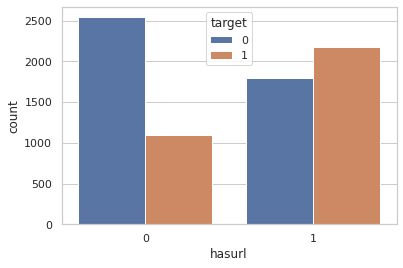

In [14]:
url = re.compile(r'https?://\S+|www\.\S+')
df_train['hasurl'] = df_train['text'].str.contains(url).astype(int)
display(HTML(df_train.sample(10, random_state=1234).to_html()))
ax0=sns.countplot(x='hasurl', hue='target', data = df_train)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


        id               keyword  ... hasurl hastag
5953  8504             screaming  ...      0      0
692    997               blazing  ...      1      0
6342  9067  structural%20failure  ...      1      0
1019  1480           body%20bags  ...      1      0
5254  7514           oil%20spill  ...      1      0
1586  2289          cliff%20fall  ...      1      0
2627  3770           destruction  ...      1      0
5937  8478              screamed  ...      1      0
3547  5071                famine  ...      1      0
5464  7797            quarantine  ...      1      1

[10 rows x 11 columns]
   id keyword location  ... hasurl  hastag              tags
0   1     NaN      NaN  ...      0       1        earthquake
1   4     NaN      NaN  ...      0       0                  
2   5     NaN      NaN  ...      0       0                  
3   6     NaN      NaN  ...      0       1         wildfires
4   7     NaN      NaN  ...      0       1  Alaska wildfires

[5 rows x 12 columns]


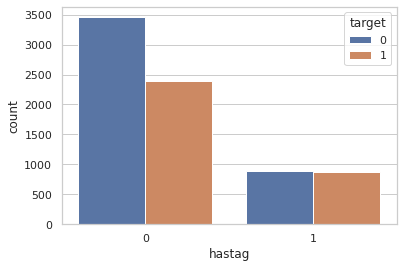

In [15]:
tag = re.compile(r'\#(\S+)')
df_train['hastag'] = df_train['text'].str.contains(tag).astype(int)
print(df_train.sample(10, random_state=1234))
ax0 = sns.countplot(x='hastag', hue='target', data=df_train)

df_train['tags'] = df_train['text'].apply(lambda x: ' '.join(re.findall(tag, x)))
print(df_train.head())


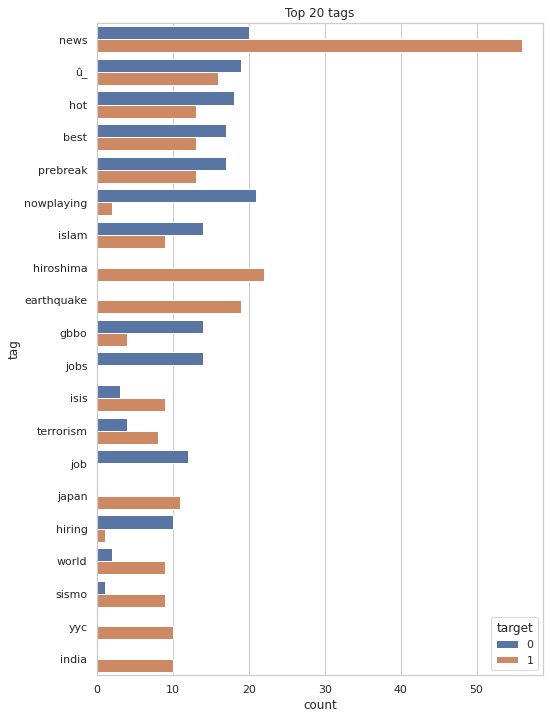

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

tag_cvec = CountVectorizer()
tag_cvec.fit(df_train['tags'])
X_tag = tag_cvec.transform(df_train['tags'])
X_tag_target0 = tag_cvec.transform(df_train[df_train['target']==0]['tags'])
X_tag_target1 = tag_cvec.transform(df_train[df_train['target']==1]['tags'])


df_tag_totcount =pd.DataFrame({ 
    'tag': tag_cvec.get_feature_names(),
    'count': X_tag.toarray().sum(axis=0)
    })
df_tag_count = pd.DataFrame({
    'tag': tag_cvec.get_feature_names(),
    'target': np.zeros(len(tag_cvec.get_feature_names()), dtype=int),
    'count': X_tag_target0.toarray().sum(axis=0)
})
df_tag_count = df_tag_count.append(pd.DataFrame({
    'tag': tag_cvec.get_feature_names(),
    'target': np.ones(len(tag_cvec.get_feature_names()), dtype=int),
    'count': X_tag_target1.toarray().sum(axis=0)
}), ignore_index=True)

fig, ax1 = plt.subplots(1,1, figsize=(8,12))
sns.barplot(y='tag', x='count', hue='target', data=df_tag_count, 
                  order = df_tag_totcount.sort_values(by='count', ascending=False)['tag'].iloc[:20])
ax1.set_title('Top 20 tags')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,id,keyword,location,text,target,haslocation,location_freq,location_count,keywords,hasurl,hastag,tags,hasat,ats
5953,8504,screaming,tx,@camilacabello97 NOW IM INTERNALLY SCREAMING,0,1,0.000394,2,screaming,0,0,,1,camilacabello97
692,997,blazing,Your screen,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures... http://t.co/ixREhM05yq,0,1,0.000394,2,blazing,1,0,,1,wo
6342,9067,structural%20failure,"Los Angeles, Calif.",NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early http://t.co/EYSbLYX6L6 via @KPCC @AP,1,1,0.000197,1,structural failure,1,0,,1,KPCC AP
1019,1480,body%20bags,Oklahoma City,Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po http://t.co/sQMTKKJiMJ,0,1,0.000591,3,body bags,1,0,,0,
5254,7514,oil%20spill,NaN,SYD traffic HAZARD Oil spill - BANKSTOWN Stacey St at Wattle St http://t.co/TZyHdBW9f5,1,0,0.000000,0,oil spill,1,0,,0,
1586,2289,cliff%20fall,Sydney Australia,News Update Huge cliff landslide on road in China - Watch the moment a cliff collapses as huge chunks of rock fall... http://t.co/gaBd0cjmAG,1,1,0.000394,2,cliff fall,1,0,,0,
2627,3770,destruction,"Manchester, England",How American war planners singled out Hiroshima for destruction http://t.co/B5OKgpSpbH,1,1,0.000787,4,destruction,1,0,,0,
5937,8478,screamed,"m3, k, a, d",I have never screamed so loud https://t.co/PC3h1NE4G0,0,1,0.000197,1,screamed,1,0,,0,
3547,5071,famine,NaN,Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/O4xLjnaV8F,1,0,0.000000,0,famine,1,0,,0,
5464,7797,quarantine,missouri USA,Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP,1,1,0.000197,1,quarantine,1,1,onlinecommunities reddit amageddon freespeech Business,0,


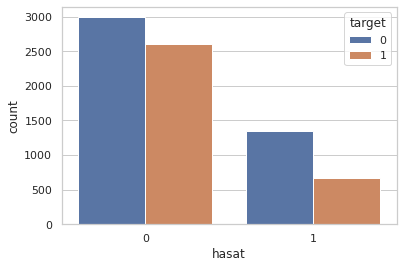

In [82]:
at = re.compile(r'\@(\S+)')
df_train['hasat'] = df_train['text'].str.contains(at).astype(int)
ax0 = sns.countplot(x='hasat', hue='target', data=df_train)

df_train['ats'] = df_train['text'].apply(lambda x: ' '.join(re.findall(at, x)))
display(HTML(df_train.sample(10, random_state=1234).to_html()))

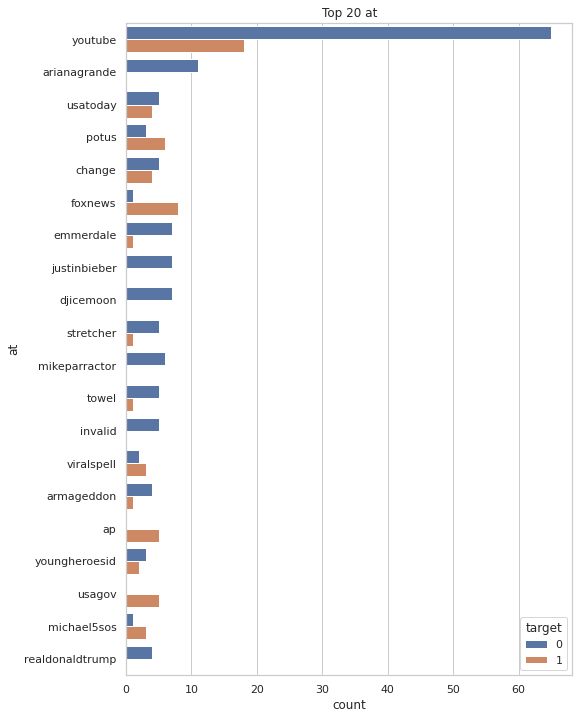

In [90]:
at_cvec = CountVectorizer()
at_cvec.fit(df_train['ats'])
X_ats = at_cvec.transform(df_train['ats'])
X_ats.sum(axis=0).max()
X_ats_target0 = at_cvec.transform(df_train[df_train['target']==0]['ats'])
X_ats_target1 = at_cvec.transform(df_train[df_train['target']==1]['ats'])

df_ats_totcount = pd.DataFrame({
    'at': at_cvec.get_feature_names(),
    'count': X_ats.toarray().sum(axis=0)
})

df_ats_count = pd.DataFrame({
    'at': at_cvec.get_feature_names(),
    'target': np.zeros(len(at_cvec.get_feature_names()), dtype=int),
    'count': X_ats_target0.toarray().sum(axis=0)
})
df_ats_count = df_ats_count.append(pd.DataFrame({
    'at': at_cvec.get_feature_names(),
    'target': np.ones(len(at_cvec.get_feature_names()), dtype=int),
    'count': X_ats_target1.toarray().sum(axis=0)
}))

fig, ax0 = plt.subplots(1,1,figsize=(8,12))
sns.barplot(y='at', x='count', hue='target', data=df_ats_count,
            order=df_ats_totcount.sort_values(by='count', ascending=False)['at'].iloc[:20])
ax0.set_title('Top 20 at')
fig.show()


In [0]:
! pip install pyspellchecker

In [0]:
from spellchecker import SpellChecker

def print_spellerror(id, text):
    sc = SpellChecker()
    mispelled = sc.unknown(text.split())
    if(mispelled):
        print(id)
        for w in mispelled:
            print(w,  sc.correction(w)) #(lambda x: sc.correction(x), for x in mispelled))
    return

#df_train[['id','text']].apply(lambda x: print_spellerror(x[0], x[1]), axis = 1, raw = True)

## Extract feature vectors
- keyword
- text

In [0]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.utils import check_array

class trans_ravel(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.ravel()

kw_vec = Pipeline([
    ('kw_imp', SimpleImputer(strategy = 'constant', fill_value='missing_value')),
    ('kw_ravel', trans_ravel()),
    ('kw_vect', CountVectorizer(decode_error = 'ignore'))
     ], verbose = True)
text_vec = Pipeline([
    ('text_tfidf', TfidfVectorizer())
    ], verbose = True)
location_vec = Pipeline([
    ('loc_imp', SimpleImputer(strategy='constant', fill_value='missing_value')),
    ('loc_ohe', OneHotEncoder(handle_unknown='ignore'))                    
], verbose = True)
transformer = ColumnTransformer(
    [('kw_cvec', kw_vec, ['keyword']),
     ('text_tvec', text_vec, 'text'),
     ('location_ohe', location_vec, ['location'])
    ],
    remainder = 'drop'
)


## Model

A first model LinearSVC

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

pip_clf = Pipeline([
    ('trans', transformer),
    ('clf', LinearSVC(dual=False))
],
verbose = True)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
    df_train[['location', 'keyword', 'text']], df_train['target'],
                     test_size = 0.3, random_state = 1234)

pip_fit = pip_clf.fit(X_train, y_train)   

According to the analysis, the conclusion



input 
    train,csv
    test.csv
    sample_submission.csv
    
output
    submission

In [0]:
from sklearn.metrics import classification_report
y_pred = pip_clf.predict(X_test)
print(classification_report(y_test, y_pred))



In [0]:
from google.colab import files
y_pred=pip_clf.predict(df_test)
df_sub = pd.DataFrame(data = 
                        {'id': df_test['id'],
                         'target': y_pred})
print(df_sub)
df_sub.to_csv(
    'predict_disastertweets_t1.csv'
)
df_sub['target'].value_counts()
#files.download('predict_disastertweets_t1.csv')
#kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

In [0]:
pip_clf.get_params()['trans__text_tvec'].get_params()['text_tfidf']

In [0]:
pip_clf['trans'].named_transformers_['text_tvec'].get_params()['text_tfidf']